In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import load
import torch

In [15]:
data_path = "../../data/mnist/"
x_test = torch.Tensor(load(f'{data_path}/x_test.npy').reshape((-1, 784)))
x_train = torch.Tensor(load(f'{data_path}/x_train.npy').reshape((-1, 784)))
y_test = torch.Tensor(load(f'{data_path}/y_test.npy'))
y_train = torch.Tensor(load(f'{data_path}/y_train.npy'))

In [16]:
print(x_train.shape)
print(y_train.shape)

print(torch.min(x_test))
print(torch.max(x_test))
print(y_train[0])


torch.Size([60000, 784])
torch.Size([60000, 10])
tensor(0.)
tensor(1.)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [36]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    # plt.show()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


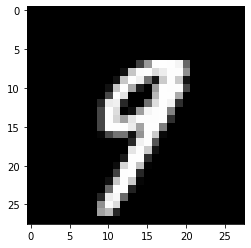

In [37]:
    
index = 12
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])
plt.show()

In [19]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

# Model

```yaml
Generator:
  - Input: 100 (90 noise, 10 one-hot)
  - h1: 150
  - h2: 400
  - h3: 784

FeatureExtractor:
  - Input: 784 (28x28)
  - h1: 400
  - h2: 150
  - h3: 100

Discriminator:
  - Input: 100
  - h1: 50
  - h2: 1

Classifier:
  - Input: 100
  - h1: 50
  - h2: 10
```

In [20]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 150)), torch.zeros(150, requires_grad=True)
        self.w2, self.b2 = get_random((150, 400)), torch.zeros(400, requires_grad=True)
        self.w3, self.b3 = get_random((400, 784)), torch.zeros(784, requires_grad=True)
    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)
        h1 = x.matmul(self.w1) + self.b1
        h2 = h1.matmul(self.w2) + self.b2
        h3 = torch.nn.functional.softmax(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [21]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 400)), torch.zeros(400, requires_grad=True)
        self.w2, self.b2 = get_random((400, 150)), torch.zeros(150, requires_grad=True)
        self.w3, self.b3 = get_random((150, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = torch.sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()
        

In [22]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 50)), torch.zeros(50, requires_grad=True)
        self.w2, self.b2 = get_random((50, 1)), torch.zeros(1, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = x.matmul(self.w1) + self.b1
        h2 = torch.sigmoid(h1.matmul(self.w2) + self.b2)
        return h2
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()

In [26]:
    
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((100, 50)), torch.zeros(50, requires_grad=True)
        self.w2, self.b2 = get_random((50, 10)), torch.zeros(10, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = torch.sigmoid(x.matmul(self.w1) + self.b1)
        h2 = torch.nn.functional.softmax(h1.matmul(self.w2) + self.b2)
        return h2
    
    def optimize(self, lr):
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()


In [27]:
fe = FeatureExtractor()
classifier = Classifier()
discriminator = Discriminator()
generator = Generator()

In [31]:
x_train = x_train[:5000]
x_test = x_test[:500]
y_train = y_train[:5000]
y_test = y_test[:500]
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5000, 784]) torch.Size([500, 784]) torch.Size([5000, 10]) torch.Size([500, 10])


In [40]:
batch_size = 20
epochs = 10

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = torch.ones(batch_size)
        fake = torch.zeros(batch_size)
        
        features = fe(x_batch)
        discriminator_out = discriminator(features)
        
        loss = torch.nn.functional.binary_cross_entropy(discriminator_out, real)
        
        loss.backward()
        discriminator.optimize(0.1)
        fe.optimize(0.1)
        
        losses[0] += float(loss)
        
        # --------------- Train with fake image -------------------
        
        generator_input = np.random.uniform(0, 1, (batch_size, 90))
        generator_input = np.concatenate((generator_input, y_batch), axis=1)
        generator_input = torch.Tensor(generator_input)
        
        generated = generator(generator_input)
        features = fe(generated)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = torch.nn.functional.binary_cross_entropy(discriminator_out, fake)
        loss_classifier = torch.nn.functional.binary_cross_entropy(classifier_out, y_batch)
        
        loss = loss_discriminator + loss_classifier
        loss.backward()
        
        discriminator.optimize(0.1)
        classifier.optimize(0.1)
        fe.optimize(0.1)
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        losses[2] += float(loss_classifier)
        
    print(f'  Losses: {losses}')


Epoch: 0
  Losses: [0.00672990788206107, 0.028761010096786777, 48.768569588661194]
Epoch: 1
  Losses: [0.008811767751581101, 0.027481034532684134, 47.616565585136414]
Epoch: 2
  Losses: [0.010753953179232667, 0.024097632722259732, 47.0744119733572]
Epoch: 3
  Losses: [0.011854831627488238, 0.02194914995925501, 46.474197670817375]
Epoch: 4
  Losses: [0.012383387664385737, 0.02030868969814037, 46.07940413057804]
Epoch: 5
  Losses: [0.012525443347612963, 0.01889376944200194, 45.76886384189129]
Epoch: 6
  Losses: [0.012373276720836657, 0.017612734793146956, 45.55451853573322]
Epoch: 7
  Losses: [0.012054564996674344, 0.016484453375596786, 45.38422194123268]
Epoch: 8
  Losses: [0.011644861357581249, 0.015484272487810813, 45.271639823913574]
Epoch: 9
  Losses: [0.011219836957593543, 0.01453532663435908, 45.131507471203804]


d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.


d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
d:\repos\ml_gallery\ml_py\venv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


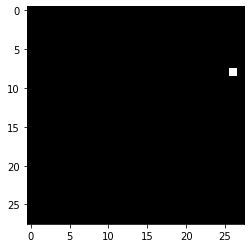

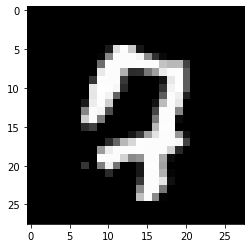

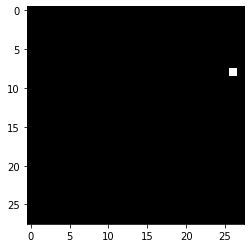

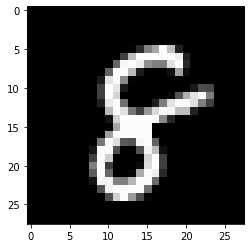

Discriminator_out: tensor([[2.1949e-06],
        [2.1949e-06]])
Real Img Discriminator Out: tensor([[1.0000],
        [1.0000]])

Class: tensor([[0.0020, 0.0044, 0.0007, 0.0054, 0.2278, 0.0079, 0.2254, 0.2684, 0.2514,
         0.0066],
        [0.0020, 0.0044, 0.0007, 0.0054, 0.2278, 0.0079, 0.2254, 0.2684, 0.2514,
         0.0066]])
Real class: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [43]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = np.random.uniform(0, 1, (batch_size, 90))
    generator_input = np.concatenate((generator_input, y_sample), axis=1)
    generator_input = torch.Tensor(generator_input)
        
    generated = generator(generator_input)
    features = fe(generated)
    discriminator_out = discriminator(features)
    classifier_out = classifier(features)
    
    real_discriminator_out = discriminator(fe(x_sample))

    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {classifier_out}\nReal class: {y_sample}")

In [ ]:
# This is just the classifier.

batch_size = 20
lr = 0.5
epochs = 10

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        
        features = fe(x_batch)
        classes = classifier(features)
        
        loss = torch.nn.functional.binary_cross_entropy(classes, y_batch)
        loss.backward()
        
        fe.optimize(lr)
        classifier.optimize(lr)
        
        losses += loss.detach().numpy()
    print(f' Loss: {losses}')

with torch.no_grad():
    index = 133
    x_sample = x_test[index:index+2]
    y_sample = y_test[index:index+2]
    y_pred = classifier(fe(x_sample))
    print(y_pred)
    print(y_sample)